# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.utils import to_categorical
from keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Dense, Activation
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

# Preprocessing

## Dataset Paths

In [13]:
# ✅ Step 1: Upload your kaggle.json
from google.colab import files
import os, json, shutil
from kaggle.api.kaggle_api_extended import KaggleApi

print("📤 Please upload your kaggle.json file:")
uploaded = files.upload()

# ✅ Step 2: Find the uploaded file
for fn in uploaded.keys():
    kaggle_src = fn  # dynamically get uploaded file name

# ✅ Step 3: Create required directories
os.makedirs("/root/.kaggle", exist_ok=True)
os.makedirs("/root/.config/kaggle", exist_ok=True)

# ✅ Step 4: Copy to both valid Kaggle paths
shutil.copy(kaggle_src, "/root/.kaggle/kaggle.json")
shutil.copy(kaggle_src, "/root/.config/kaggle/kaggle.json")

# ✅ Step 5: Set correct permissions
os.chmod("/root/.kaggle/kaggle.json", 0o600)
os.chmod("/root/.config/kaggle/kaggle.json", 0o600)

# ✅ Step 6: Validate kaggle.json contents
with open("/root/.kaggle/kaggle.json", "r") as f:
    creds = json.load(f)
    assert "username" in creds and "key" in creds, "❌ Invalid kaggle.json format!"

# ✅ Step 7: Authenticate with Kaggle
api = KaggleApi()
api.authenticate()
print("✅ Kaggle authentication successful!")

# ✅ Step 8: Download & unzip the dataset
DATA_DIR = "./gtsrb-data"
os.makedirs(DATA_DIR, exist_ok=True)

dataset_name = "meowmeowmeowmeowmeow/gtsrb-german-traffic-sign"
print(f"⬇️ Downloading dataset: {dataset_name} …")
api.dataset_download_files(dataset_name, path=DATA_DIR, unzip=True)
print("✅ Dataset downloaded and extracted successfully!")

# ✅ Step 9: Define directories and parameters
TRAIN_DIR = os.path.join(DATA_DIR, "Train")
TEST_DIR = os.path.join(DATA_DIR, "Test")

IMG_HEIGHT, IMG_WIDTH, channels = 30, 30, 3

print("TRAIN_DIR:", TRAIN_DIR)
print("TEST_DIR:", TEST_DIR)


📤 Please upload your kaggle.json file:


Saving kaggle.json to kaggle (2).json
✅ Kaggle authentication successful!
⬇️ Downloading dataset: meowmeowmeowmeowmeow/gtsrb-german-traffic-sign …
Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
✅ Dataset downloaded and extracted successfully!
TRAIN_DIR: ./gtsrb-data/Train
TEST_DIR: ./gtsrb-data/Test


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [14]:
classes = {
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)',
    2:'Speed limit (50km/h)',
    3:'Speed limit (60km/h)',
    4:'Speed limit (70km/h)',
    5:'Speed limit (80km/h)',
    6:'End of speed limit (80km/h)',
    7:'Speed limit (100km/h)',
    8:'Speed limit (120km/h)',
    9:'No passing',
    10:'No passing veh over 3.5 tons',
    11:'Right-of-way at intersection',
    12:'Priority road',
    13:'Yield',
    14:'Stop',
    15:'No vehicles',
    16:'Veh > 3.5 tons prohibited',
    17:'No entry',
    18:'General caution',
    19:'Dangerous curve left',
    20:'Dangerous curve right',
    21:'Double curve',
    22:'Bumpy road',
    23:'Slippery road',
    24:'Road narrows on the right',
    25:'Road work',
    26:'Traffic signals',
    27:'Pedestrians',
    28:'Children crossing',
    29:'Bicycles crossing',
    30:'Beware of ice/snow',
    31:'Wild animals crossing',
    32:'End speed + passing limits',
    33:'Turn right ahead',
    34:'Turn left ahead',
    35:'Ahead only',
    36:'Go straight or right',
    37:'Go straight or left',
    38:'Keep right',
    39:'Keep left',
    40:'Roundabout mandatory',
    41:'End of no passing',
    42:'End no passing veh > 3.5 tons'
}

## Visualizing the Dataset

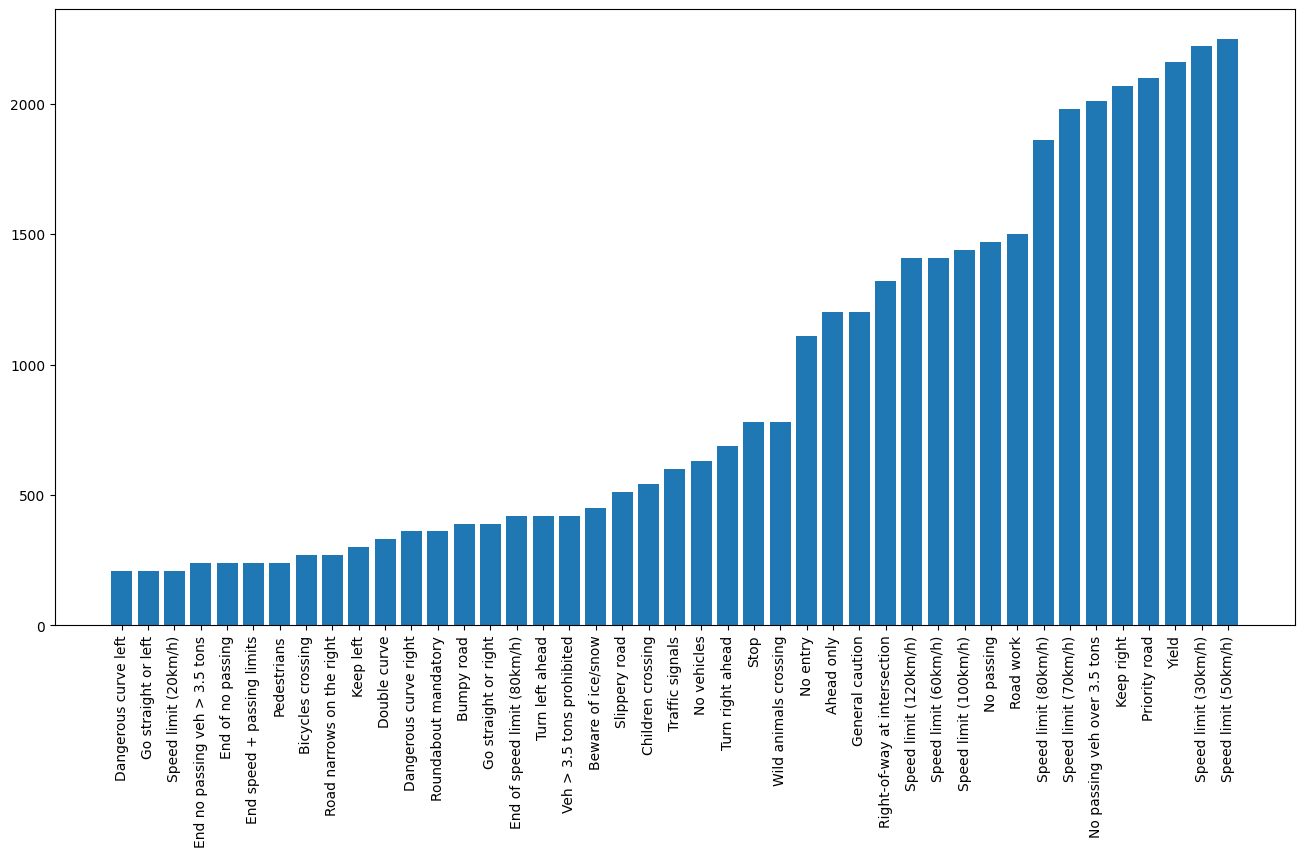

In [15]:
folders = os.listdir(TRAIN_DIR)
train_num = []
class_num = []

for folder in folders:
    train_files = os.listdir(os.path.join(TRAIN_DIR, folder))
    train_num.append(len(train_files))
    class_num.append(classes[int(folder)])

zipped_lists = zip(train_num, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_num, class_num = [ list(tuple) for tuple in  tuples]

# Plotting number of images in each class
plt.figure(figsize=(16, 8))
plt.bar(class_num, train_num)
plt.xticks(class_num, rotation='vertical')
plt.show()

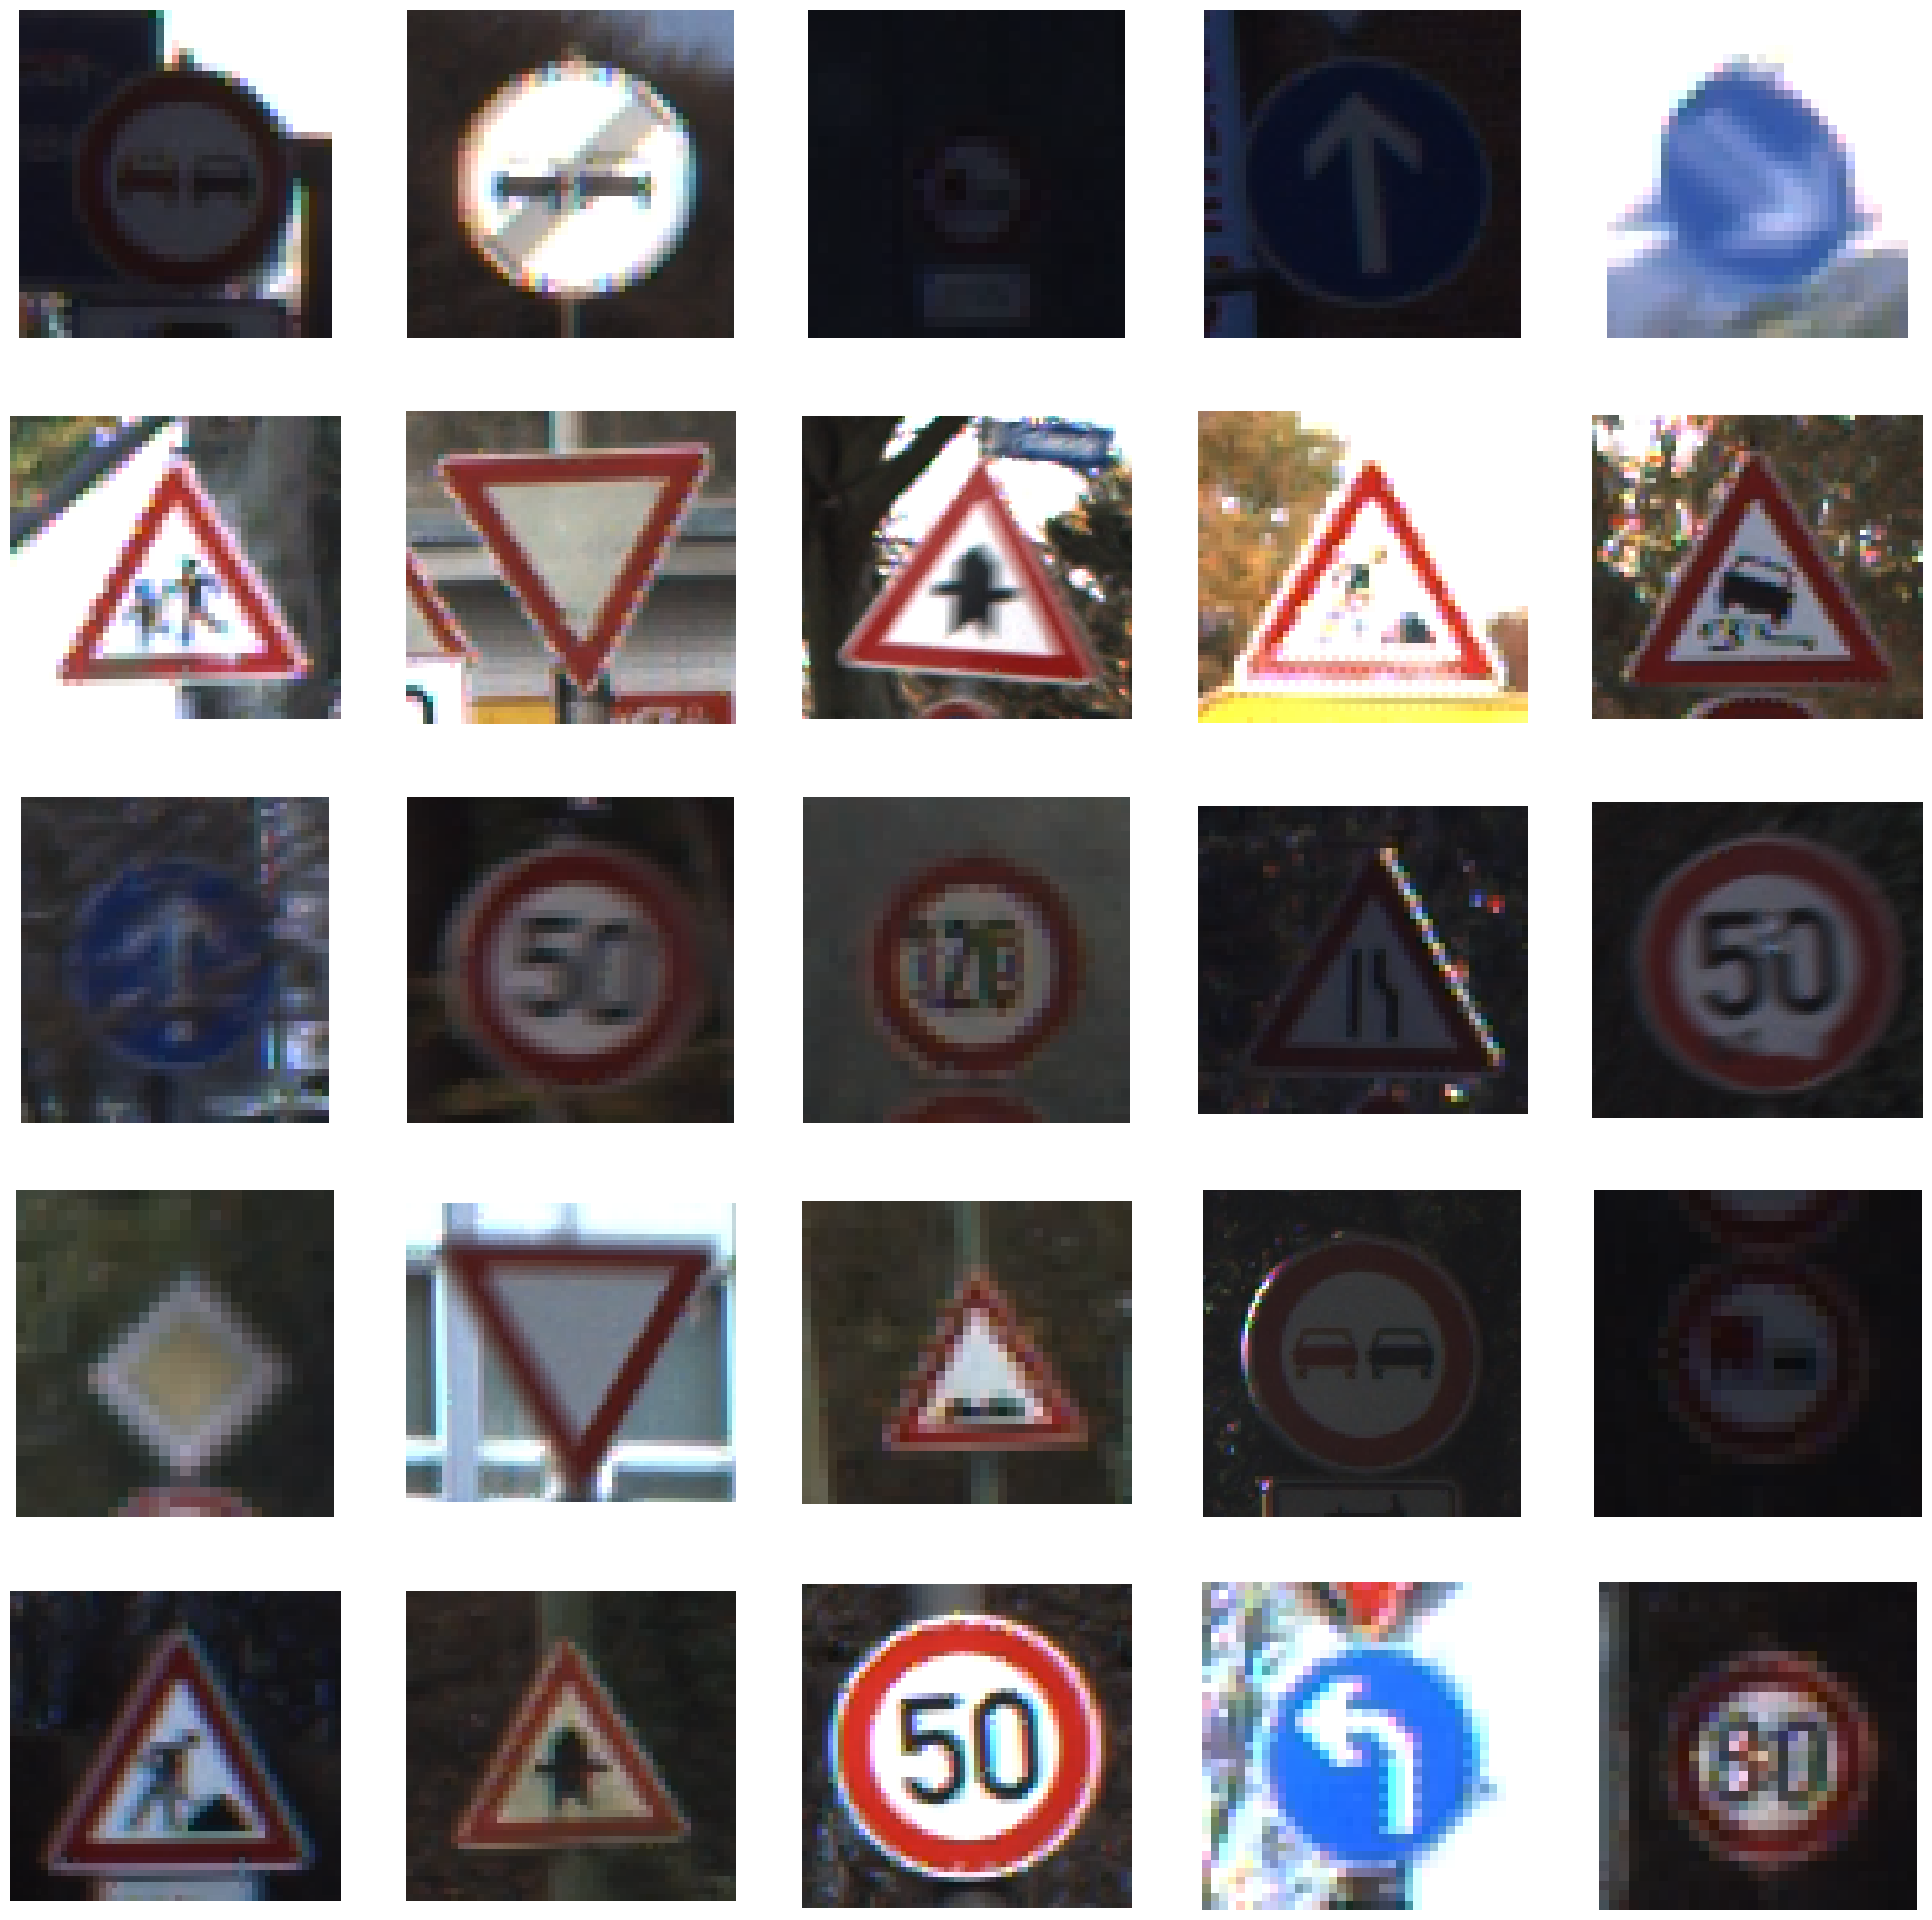

In [16]:
test = pd.read_csv(os.path.join(DATA_DIR, "Test.csv"))
imgs = test["Path"].values
plt.figure(figsize=(25, 25))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_img_path = os.path.join(DATA_DIR, random.choice(imgs))
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    # plt.grid(b=None)
    plt.axis("off")

## Collecting the Training Data

In [17]:
%%time
image_data = []
image_labels = []

for i in range(43):
    path = os.path.join(TRAIN_DIR, str(i))
    images = os.listdir(path)
    for img in images:
        try:
            image = cv2.imread(os.path.join(path, img))
            image_fromarray = Image.fromarray(image, "RGB")
            resized_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resized_image))
            image_labels.append(i)
        except:
            print(f"Error in {img}")

# Changing lists to numpy arrays
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(f"Image Data -> {image_data.shape}")
print(f"Image Labels -> {image_labels.shape}")

<timed exec>:10: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)


Image Data -> (39209, 30, 30, 3)
Image Labels -> (39209,)
CPU times: user 11.5 s, sys: 1.14 s, total: 12.7 s
Wall time: 13.9 s


## Splitting the data into train and validation sets

In [18]:
# Shuffling the data
shuffled_indices = np.arange(image_data.shape[0])
np.random.shuffle(shuffled_indices)
print(shuffled_indices)
image_data = image_data[shuffled_indices]
image_labels = image_labels[shuffled_indices]

# Now let's split the data
X_train, X_valid, y_train, y_valid = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255.
X_valid = X_valid/255.

print("X_train ->", X_train.shape)
print("X_valid ->", X_valid.shape)
print("y_train ->", y_train.shape)
print("y_valid ->", y_valid.shape)

[25625 14251 23675 ...  7088 29182 36549]
X_train -> (27446, 30, 30, 3)
X_valid -> (11763, 30, 30, 3)
y_train -> (27446,)
y_valid -> (11763,)


## One Hot encoding the labels

In [19]:
y_train = to_categorical(y_train, 43)
y_valid = to_categorical(y_valid, 43)

print("y_train ->", y_train.shape)
print("y_valid ->", y_valid.shape)

y_train -> (27446, 43)
y_valid -> (11763, 43)


# Model

## Building the Model

In [20]:
model = keras.models.Sequential([
    Input((IMG_HEIGHT, IMG_WIDTH, channels)),
    Conv2D(16, (5, 5)),
    Conv2D(32, (5, 5)),
    BatchNormalization(axis=-1),
    Activation('relu'),
    MaxPool2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3)),
    Conv2D(128, (3, 3)),
    BatchNormalization(axis=-1),
    Activation('relu'),
    MaxPool2D((2, 2)),
    Dropout(0.25),

    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(43, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 16)     │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 22, 22, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,195 (770.29 KB)

 Trainable params: 195,851 (765.04 KB)

 Non-trainable params: 1,344 (5.25 KB)

In [21]:
lr = 0.001
epochs = 20

opt = keras.optimizers.Adam(learning_rate=lr)
loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.08)
model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])

In [22]:
augmentor = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest"
)

In [23]:
%%time
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

history = model.fit(augmentor.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


856/858 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2547 - loss: 3.1967

858/858 ━━━━━━━━━━━━━━━━━━━━ 34s 29ms/step - accuracy: 0.2552 - loss: 3.1942 - val_accuracy: 0.7544 - val_loss: 1.3644 - learning_rate: 0.0010
Epoch 2/20
857/858 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6625 - loss: 1.6413

858/858 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6626 - loss: 1.6411 - val_accuracy: 0.8575 - val_loss: 1.1228 - learning_rate: 0.0010
Epoch 3/20
856/858 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7598 - loss: 1.3724

858/858 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.7598 - loss: 1.3723 - val_accuracy: 0.9103 - val_loss: 0.9783 - learning_rate: 0.0010
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8190 - loss: 1.2261

858/858 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.8191 - loss: 1.2260 - val_accuracy: 0.9540 - val_loss: 0.9155 - learning_rate: 0.0010
Epoch 5/20
856/858 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8529 - loss: 1.1343

858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.8529 - loss: 1.1342 - val_accuracy: 0.9683 - val_loss: 0.8501 - learning_rate: 0.0010
Epoch 6/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8745 - loss: 1.0732

858/858 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.8745 - loss: 1.0732 - val_accuracy: 0.9775 - val_loss: 0.8050 - learning_rate: 0.0010
Epoch 7/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8866 - loss: 1.0425

858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.8866 - loss: 1.0425 - val_accuracy: 0.9823 - val_loss: 0.7930 - learning_rate: 0.0010
Epoch 8/20
857/858 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9015 - loss: 0.9941

858/858 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9015 - loss: 0.9941 - val_accuracy: 0.9845 - val_loss: 0.7738 - learning_rate: 0.0010
Epoch 9/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.9075 - loss: 0.9659 - val_accuracy: 0.9843 - val_loss: 0.7576 - learning_rate: 0.0010
Epoch 10/20
856/858 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9194 - loss: 0.9363

858/858 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9194 - loss: 0.9362 - val_accuracy: 0.9927 - val_loss: 0.7605 - learning_rate: 0.0010
Epoch 11/20
857/858 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9283 - loss: 0.9072

858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.9283 - loss: 0.9072 - val_accuracy: 0.9928 - val_loss: 0.7217 - learning_rate: 0.0010
Epoch 12/20
856/858 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9327 - loss: 0.8920

858/858 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9328 - loss: 0.8920 - val_accuracy: 0.9933 - val_loss: 0.7643 - learning_rate: 0.0010
Epoch 13/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.9375 - loss: 0.8753 - val_accuracy: 0.9918 - val_loss: 0.7146 - learning_rate: 0.0010
Epoch 14/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9463 - loss: 0.8625 - val_accuracy: 0.9918 - val_loss: 0.7101 - learning_rate: 0.0010
Epoch 15/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.9468 - loss: 0.8497 - val_accuracy: 0.9920 - val_loss: 0.7268 - learning_rate: 0.0010
Epoch 16/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9489 - loss: 0.8450

858/858 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9489 - loss: 0.8450 - val_accuracy: 0.9935 - val_loss: 0.6970 - learning_rate: 0.0010
Epoch 17/20
857/858 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9489 - loss: 0.8366

858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.9489 - loss: 0.8366 - val_accuracy: 0.9949 - val_loss: 0.6979 - learning_rate: 0.0010
Epoch 18/20
856/858 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9527 - loss: 0.8229

858/858 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9527 - loss: 0.8229 - val_accuracy: 0.9950 - val_loss: 0.6746 - learning_rate: 0.0010
Epoch 19/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.9557 - loss: 0.8203 - val_accuracy: 0.9941 - val_loss: 0.6992 - learning_rate: 0.0010
Epoch 20/20
857/858 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9537 - loss: 0.8186

858/858 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9537 - loss: 0.8185 - val_accuracy: 0.9957 - val_loss: 0.7119 - learning_rate: 0.0010
CPU times: user 7min 11s, sys: 12.7 s, total: 7min 24s
Wall time: 6min 29s


# Visualizing results

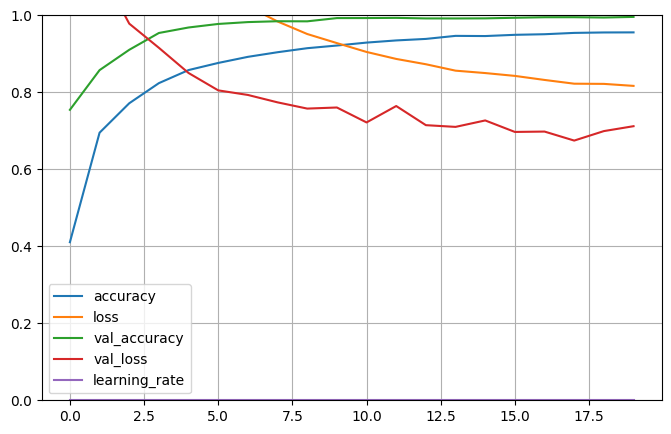

In [24]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### Collecting Test Data and Evaluating the Model

In [25]:
test = pd.read_csv(os.path.join(DATA_DIR, 'Test.csv'))

labels = test["ClassId"].values
imgs = test["Path"].values

data = []

for img in imgs:
    try:
        image = cv2.imread(os.path.join(DATA_DIR, img))
        image_fromarray = Image.fromarray(image, 'RGB')
        resized_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resized_image))
    except:
        print("Error in " + img)

X_test = np.array(data)
X_test = X_test/255.
labels = np.array(labels)
y_test = to_categorical(labels, 43)

/tmp/ipython-input-3936769919.py:11: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image_fromarray = Image.fromarray(image, 'RGB')


In [26]:
model.evaluate(X_test, y_test)

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9651 - loss: 0.7484


[0.7505772113800049, 0.9649247527122498]

### Visualizing the Confusion Matrix

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


<Axes: >

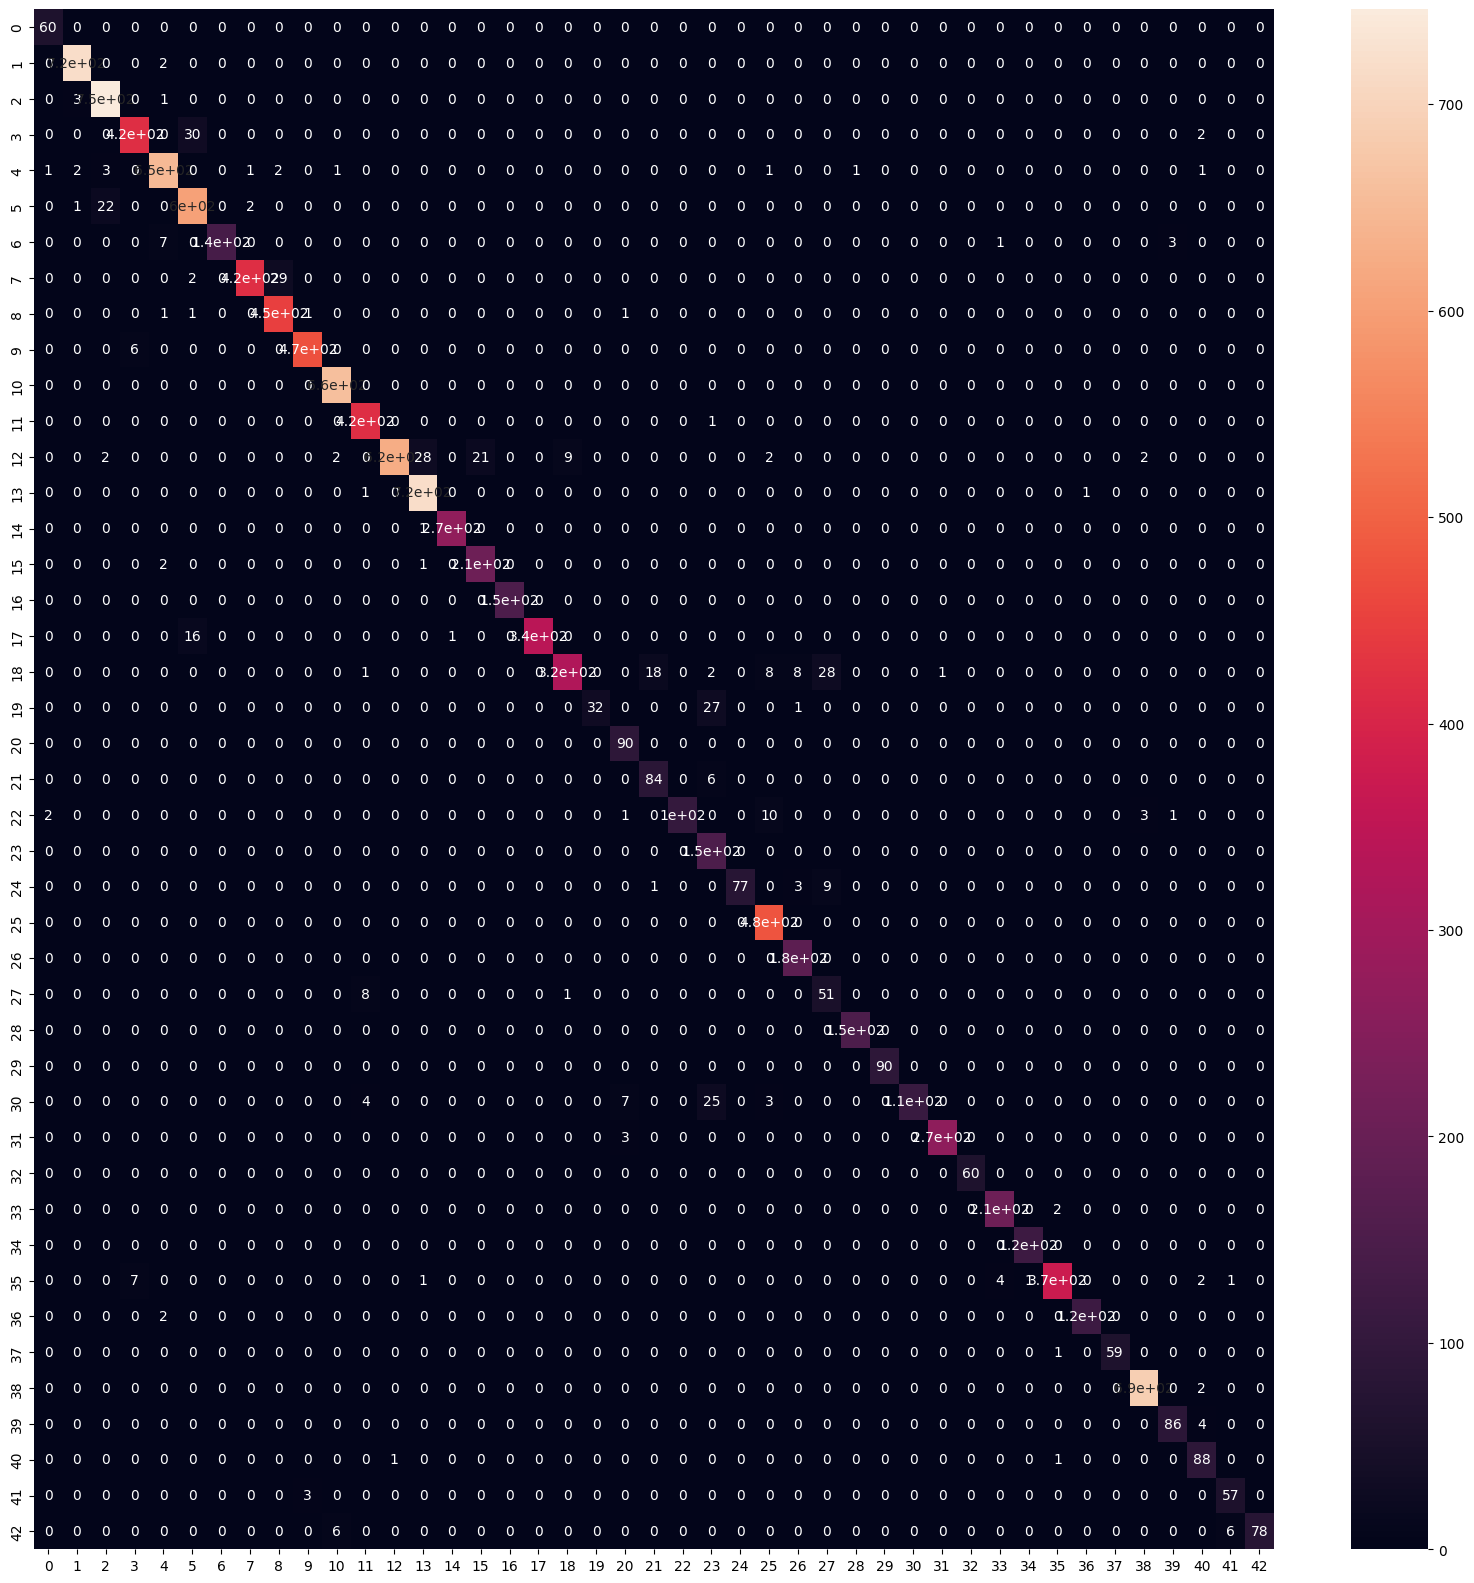

In [27]:
preds = model.predict(X_test)
cf = confusion_matrix(labels, np.argmax(preds, axis=1))

import seaborn as sns
df_cm = pd.DataFrame(cf, index=classes, columns=classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

### Classification Report

In [28]:
print(classification_report(labels, np.argmax(preds, axis=1)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       0.99      1.00      0.99       720
           2       0.97      0.99      0.98       750
           3       0.97      0.93      0.95       450
           4       0.98      0.98      0.98       660
           5       0.93      0.96      0.94       630
           6       1.00      0.93      0.96       150
           7       0.99      0.93      0.96       450
           8       0.94      0.99      0.96       450
           9       0.99      0.99      0.99       480
          10       0.99      1.00      0.99       660
          11       0.97      1.00      0.98       420
          12       1.00      0.90      0.95       690
          13       0.96      1.00      0.98       720
          14       1.00      1.00      1.00       270
          15       0.91      0.99      0.95       210
          16       1.00      1.00      1.00       150
          17       1.00    

# Now let's save our model

In [ ]:
model.save("traffic_sign_model.h5")